<a href="https://colab.research.google.com/github/MattoDemente/CryptoTrading/blob/master/TOG_Labeling%2BLSTM_06252020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COmbinar con Datos etiquetados de arglextrema
Hacer un pipeline integrado
* Puede ser cargar datos de archivo ya etiquetado

Observaciones de Profesores durante Sesiones de Asesoría
* Hacer clasificador
* En la última capa poner un Softmax, 
* Medir accuracy (clasificación correcta o incorrecta)
*   Curva ROC
* Usar SoftMax en última capa.
* Usar Cross Entropy
* Mejorar distribución de clases

* Ventana de 40 y ventana de 20 se volvió ventana de 7 y ventana de 18-20

* Batch 
* Shuffle
* Scale

In [249]:
#!pip install backtesting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [250]:
#!pip show pandas
import pandas as pd
import numpy as np
from scipy import interp
import time
import os
import re
import tensorflow as tf
from scipy.signal import argrelextrema
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import cycle
from tqdm import tqdm
from termcolor import colored, cprint
import math
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import Dropout
#from keras.layers import TimeDistributed
#from keras.utils import to_categorical
#from keras.layers import Activation
#from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import ModelCheckpoint
#from tensorflow.data import Dataset
import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

%matplotlib inline



from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Carga de datos de paridad BTC a TUSD
## * Cambio por dataset YA Etiquetado


In [251]:
#Pulling BITCOIN MXN
def load_crncy(path, kind='train'):
    """Load Bitcoin MXN trade info"""
    
    data_path = os.path.join(path, 'Binance_BTCUSDT_1h_labeled_1_window_propagated_blocks.csv')
    #data_path = os.path.join(path, 'Bitso_ETHMXN_1h_20191206.csv')
    #X = np.genfromtxt(fname=data_path,delimiter=',', skip_header=2,usecols=(0,1,2,3,4,5,6,7))    
    #df = pd.read_csv(data_path, sep = ",",skiprows = 1, index_col='Date')
    df = pd.read_csv(data_path, sep = ",",skiprows = 0, index_col=0)
    #df = df.iloc[ : , 0:8]
    print('First rows of features')
    print(df.head)
    #print(df.isna().sum())
    '''
    y = np.genfromtxt(fname=data_path,delimiter=',', skip_header=1, usecols=(11))    
    print('First value of targets ',y[0])
    print('Shape of Data loaded ',X.shape, y.shape)    
    '''
    return df
    

In [252]:
data_frame = load_crncy('/content/gdrive/My Drive/Colab Notebooks/BINANCE/data/')    

First rows of features
<bound method NDFrame.head of                         Open     High  ...  position_block_delta_pct  positionW
2017-08-16 23:00:00  4261.48  4313.62  ...                       0.0          0
2017-08-17 00:00:00  4308.83  4328.69  ...                       0.0          0
2017-08-17 01:00:00  4330.29  4345.45  ...                       0.0          0
2017-08-17 02:00:00  4316.62  4349.99  ...                       0.0          0
2017-08-17 03:00:00  4333.32  4377.85  ...                       0.0          0
...                      ...      ...  ...                       ...        ...
2020-06-18 15:00:00  9397.99  9404.28  ...                       0.0          0
2020-06-18 16:00:00  9343.98  9390.84  ...                       0.0          0
2020-06-18 17:00:00  9371.28  9395.00  ...                       0.0          0
2020-06-18 18:00:00  9379.63  9416.65  ...                       0.0          0
2020-06-18 19:00:00  9386.32  9388.71  ...                       0.

In [253]:
data_frame.dtypes

Open                        float64
High                        float64
Low                         float64
Close                       float64
position                    float64
propagated_position         float64
position_block               object
position_close              float64
position_block_delta_pct    float64
positionW                     int64
dtype: object

# Se crea índice de tipo Timestamp y se valida el dataset

In [254]:
data_frame.head(32)

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.000000,0
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.000000,0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.000000,0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.000000,0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.000000,0
2017-08-17 04:00:00,4360.00,4445.78,4360.00,4444.00,0.0,0.0,2017-08-17 04:00:00,4444.00,0.000000,0
2017-08-17 05:00:00,4441.10,4470.00,4399.81,4460.00,0.0,0.0,2017-08-17 05:00:00,4460.00,0.000000,0
2017-08-17 06:00:00,4460.00,4485.39,4427.30,4427.30,0.0,0.0,2017-08-17 06:00:00,4427.30,0.000000,0
2017-08-17 07:00:00,4436.06,4449.56,4411.00,4411.00,0.0,0.0,2017-08-17 07:00:00,4411.00,0.000000,0
2017-08-17 08:00:00,4411.00,4459.00,4411.00,4459.00,0.0,0.0,2017-08-17 08:00:00,4459.00,0.000000,0


In [255]:
data_frame['date_time'] = data_frame.index

In [256]:
data_frame['date_time'] = data_frame.date_time.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [257]:
data_frame.dtypes

Open                               float64
High                               float64
Low                                float64
Close                              float64
position                           float64
propagated_position                float64
position_block                      object
position_close                     float64
position_block_delta_pct           float64
positionW                            int64
date_time                   datetime64[ns]
dtype: object

In [258]:
data_frame.index = data_frame.date_time

In [259]:
data_frame = data_frame.drop(['date_time' ], axis=1)

In [260]:
data_frame.head()

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
date_time,,,,,,,,,,
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.0,0
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.0,0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.0,0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.0,0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.0,0


In [261]:
data_frame.index.dtype

dtype('<M8[ns]')

In [262]:
len(data_frame)

24885

# Se elimina columna de fecha original del archvo de datos en formato de cadena y se ordena el dataset

In [263]:
df = data_frame.copy(deep=True)
"""
#df = data_frame
df = pd.DataFrame()
df['Open'] = data_frame['Open']
df['High'] = data_frame['High']
df['Low'] = data_frame['Low']
df['Close'] = data_frame['Close']
df['Volume'] = data_frame['Volume BTC']
df = df.sort_index(ascending=True)
df.head(32)
"""

"\n#df = data_frame\ndf = pd.DataFrame()\ndf['Open'] = data_frame['Open']\ndf['High'] = data_frame['High']\ndf['Low'] = data_frame['Low']\ndf['Close'] = data_frame['Close']\ndf['Volume'] = data_frame['Volume BTC']\ndf = df.sort_index(ascending=True)\ndf.head(32)\n"

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcfbc4cf908>,
      dtype=object)

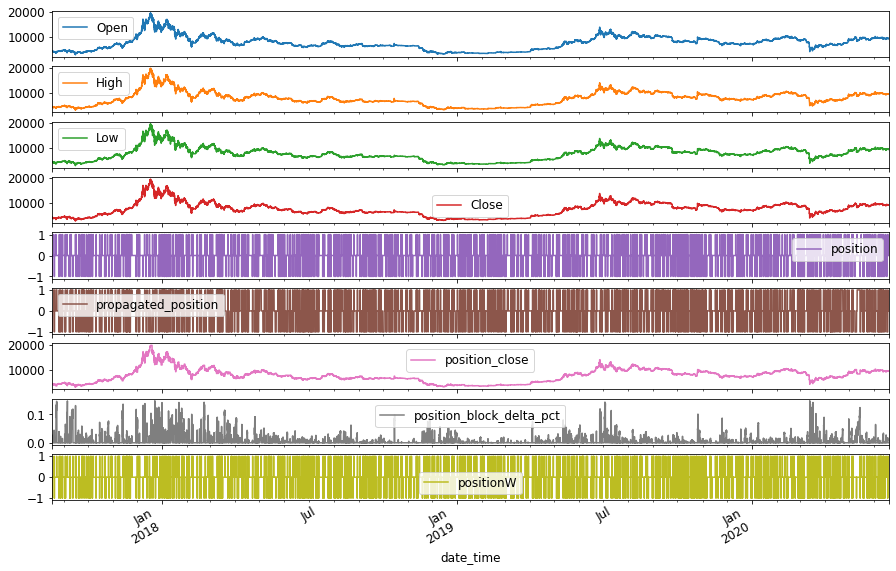

In [264]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font',**font)        

df.plot(figsize=(15,10),subplots=True)

In [265]:
df.tail()

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
date_time,,,,,,,,,,
2020-06-18 15:00:00,9397.99,9404.28,9313.00,9343.97,0.0,0.0,2020-06-18 15:00:00,9343.97,0.0,0
2020-06-18 16:00:00,9343.98,9390.84,9280.00,9371.28,0.0,0.0,2020-06-18 16:00:00,9371.28,0.0,0
2020-06-18 17:00:00,9371.28,9395.00,9361.37,9379.98,0.0,0.0,2020-06-18 17:00:00,9379.98,0.0,0
2020-06-18 18:00:00,9379.63,9416.65,9367.65,9386.32,0.0,0.0,2020-06-18 18:00:00,9386.32,0.0,0
2020-06-18 19:00:00,9386.32,9388.71,9325.16,9371.79,0.0,0.0,2020-06-18 19:00:00,9371.79,0.0,0


In [266]:
data_frame.head(32)

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
date_time,,,,,,,,,,
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.000000,0
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.000000,0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.000000,0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.000000,0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.000000,0
2017-08-17 04:00:00,4360.00,4445.78,4360.00,4444.00,0.0,0.0,2017-08-17 04:00:00,4444.00,0.000000,0
2017-08-17 05:00:00,4441.10,4470.00,4399.81,4460.00,0.0,0.0,2017-08-17 05:00:00,4460.00,0.000000,0
2017-08-17 06:00:00,4460.00,4485.39,4427.30,4427.30,0.0,0.0,2017-08-17 06:00:00,4427.30,0.000000,0
2017-08-17 07:00:00,4436.06,4449.56,4411.00,4411.00,0.0,0.0,2017-08-17 07:00:00,4411.00,0.000000,0


In [267]:
len(df)

24885

In [268]:
#df2 = re_label(df1)
df2 = df.copy()

In [269]:
df2.head()

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
date_time,,,,,,,,,,
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.0,0
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.0,0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.0,0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.0,0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.0,0


In [270]:
date_rng = pd.date_range(start='2017-12-01 00:00:00', end='2017-12-31 23:00:00', freq='H')

In [271]:
df2['position'].value_counts()

 0.0    23996
-1.0      446
 1.0      443
Name: position, dtype: int64

In [272]:
print(len(df2))
print(f"propagated position 1 : {len(df2[df2['propagated_position'] == 1])}")
print(f"propagated position -1 : {len(df2[df2['propagated_position'] == -1])}")
print(f"propagated position 0 : {len(df2[df2['propagated_position'] == 0])}")
print(f"propagated position 2 : {len(df2[df2['propagated_position'] == 2])}")
print(f"propagated position -2 : {len(df2[df2['propagated_position'] == -2])}")

24885
propagated position 1 : 3416
propagated position -1 : 3684
propagated position 0 : 17785
propagated position 2 : 0
propagated position -2 : 0


In [273]:
date_rng = pd.date_range(start='2017-12-01 00:00:00', end='2017-12-31 23:00:00', freq='H')

In [274]:
df2.loc[date_rng]

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
2017-12-01 00:00:00,9575.04,9676.38,9436.01,9449.93,0.0,1.0,2017-11-30 09:00:00,8980.00,0.049728,0
2017-12-01 01:00:00,9437.99,9560.00,9380.00,9540.00,0.0,1.0,2017-11-30 09:00:00,8980.00,0.058700,0
2017-12-01 02:00:00,9540.00,9819.99,9540.00,9780.63,0.0,1.0,2017-11-30 09:00:00,8980.00,0.081859,0
2017-12-01 03:00:00,9780.63,9987.00,9748.99,9985.00,0.0,0.0,2017-12-01 03:00:00,9985.00,0.000000,0
2017-12-01 04:00:00,9984.02,10000.00,9758.13,9760.09,0.0,0.0,2017-12-01 04:00:00,9760.09,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00,13528.99,13595.89,13155.38,13203.06,0.0,0.0,2017-12-31 19:00:00,13203.06,0.000000,0
2017-12-31 20:00:00,13203.00,13418.43,13200.00,13330.18,0.0,0.0,2017-12-31 20:00:00,13330.18,0.000000,0
2017-12-31 21:00:00,13330.26,13611.27,13290.00,13410.03,0.0,0.0,2017-12-31 21:00:00,13410.03,0.000000,0
2017-12-31 22:00:00,13434.98,13623.29,13322.15,13601.01,0.0,0.0,2017-12-31 22:00:00,13601.01,0.000000,0


In [275]:
df2.tail()

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
date_time,,,,,,,,,,
2020-06-18 15:00:00,9397.99,9404.28,9313.00,9343.97,0.0,0.0,2020-06-18 15:00:00,9343.97,0.0,0
2020-06-18 16:00:00,9343.98,9390.84,9280.00,9371.28,0.0,0.0,2020-06-18 16:00:00,9371.28,0.0,0
2020-06-18 17:00:00,9371.28,9395.00,9361.37,9379.98,0.0,0.0,2020-06-18 17:00:00,9379.98,0.0,0
2020-06-18 18:00:00,9379.63,9416.65,9367.65,9386.32,0.0,0.0,2020-06-18 18:00:00,9386.32,0.0,0
2020-06-18 19:00:00,9386.32,9388.71,9325.16,9371.79,0.0,0.0,2020-06-18 19:00:00,9371.79,0.0,0


In [276]:
"""
plt.figure(figsize=[40,10])
plt.grid(True)
plt.plot(df2['Close'],label='Close Price MXN')
#plt.plot(df2['Close mean'],label='Rolling Mean Price MXN')
#plt.plot(df2['Close std Dev'],label='Std Dev Price MXN')

#plt.plot(df2['mx'], fillstyle='none',label='Maximums')
#plt.plot(df2['mn'], fillstyle='none',label='Minimums')
plt.plot(df2[df2['positionW']== 2]['Close'],'v', color='black', fillstyle='full',label='Top Maximum')
plt.plot(df2[df2['positionW'] == 1]['Close'],'v', color='green', fillstyle='full',label='Local Maximum')
plt.plot(df2[df2['positionW']== -1]['Close'],'^', color='orange', fillstyle='full',label='Local Minimum')
plt.plot(df2[df2['positionW'] == -2]['Close'],'^', color='red', fillstyle='full',label='Bottom Minimum')

#plt.axhline(75641.024, alpha=0.7, linestyle='dotted', color='red')
#plt.axhline(121000.0, alpha=0.7, linestyle='dotted', color='red')
#plt.axhline(144841.768, alpha=0.7, linestyle='dotted', color='red')
#plt.axhline(190588.008, alpha=0.7, linestyle='dotted', color='red')
#plt.axhline(397998.76, alpha=0.7, linestyle='dotted', color='red')
#plt.fill_between(date_rng_total,df2['mx'], df2['mn'], facecolor='yellow', alpha=0.10)

plt.legend(loc=2)
"""
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df2.index, y=df2['Close'],
                    mode='lines',
                    name='Close'))

fig.add_trace(go.Scatter(x=df2[df2['propagated_position'] == -2].index, y=df2[df2['propagated_position'] == -2]['Close'],
                    mode='markers',
                    name='Top Sale'))
fig.add_trace(go.Scatter(x=df2[df2['propagated_position'] == -1].index, y=df2[df2['propagated_position'] == -1]['Close'],
                    mode='markers',
                    name='Sale'))
fig.add_trace(go.Scatter(x=df2[df2['propagated_position'] == 1].index, y=df2[df2['propagated_position'] == 1]['Close'],
                    mode='markers',
                    name='Buy'))
fig.add_trace(go.Scatter(x=df2[df2['propagated_position'] == 2].index, y=df2[df2['propagated_position'] == 2]['Close'],
                    mode='markers',
                    name='Top Buy'))


fig.show()



Definir rango de medición de errores máximos y mínimos para el modelo (definir porcentaje)

In [277]:
date_rng = pd.date_range(start='2017-11-23 00:00:00', end='2017-12-10 23:00:00', freq='H')

In [354]:
"""
plt.figure(figsize=[40,10])
plt.grid(True)
plt.plot(df2['Close'].loc[date_rng],label='Close Price MXN')
#plt.plot(df2['Close mean'].loc[date_rng],label='Rolling Mean Price MXN')
#plt.plot(df2['Close std Dev'].loc[date_rng],label='Std Dev Price MXN')
#plt.plot(df2['rolling mean'].loc[date_rng], fillstyle='none',label='rma')
plt.plot(df2['Close'].loc[date_rng], fillstyle='none',label='Maximums')
plt.plot(df2['Close'].loc[date_rng], fillstyle='none',label='Minimums')
plt.plot(df2.loc[date_rng][df2['position'] == 2]['Close'],'v', color='black', fillstyle='full',label='G Maximum')
plt.plot(df2.loc[date_rng][df2['position'] == 1]['Close'],'v', color='green', fillstyle='full',label='L Maximum')
plt.plot(df2.loc[date_rng][df2['position']== -1]['Close'],'^', color='orange', fillstyle='full',label='L Minimum')
plt.plot(df2.loc[date_rng][df2['position']== -2]['Close'],'^', color='red', fillstyle='full',label='G Minimum')
#plt.fill_between(date_rng, df2['mx'].loc[date_rng], df2['mn'].loc[date_rng], facecolor='yellow', alpha=0.10)
#plt.plot(data_frame['Position'].loc['2017-07-07':'2017-07-13'],'^', fillstyle='none',label='Bollinger Lower')
plt.legend(loc=1)
"""
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df2.index, y=df2['Close'],
                    mode='lines',
                    name='Close'))

fig.add_trace(go.Scatter(x=df2[df2['position'] == -2].index, y=df2[df2['position'] == -2]['Close'],
                    mode='markers',
                    name='Top Sale'))
fig.add_trace(go.Scatter(x=df2[df2['position'] == -1].index, y=df2[df2['position'] == -1]['Close'],
                    mode='markers',
                    name='Sale'))
fig.add_trace(go.Scatter(x=df2[df2['position'] == 1].index, y=df2[df2['position'] == 1]['Close'],
                    mode='markers',
                    name='Buy'))
fig.add_trace(go.Scatter(x=df2[df2['position'] == 2].index, y=df2[df2['position'] == 2]['Close'],
                    mode='markers',
                    name='Top Buy'))


fig.show()


In [279]:
positions=df2['position'].to_numpy(dtype=int)
positions

array([0, 0, 0, ..., 0, 0, 0])

In [280]:
signal = pd.Series(positions)

signal

0        0
1        0
2        0
3        0
4        0
        ..
24880    0
24881    0
24882    0
24883    0
24884    0
Length: 24885, dtype: int64

In [281]:
df2.head()

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW
date_time,,,,,,,,,,
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.0,0
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.0,0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.0,0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.0,0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.0,0


# Agregamos columna de posición previa al dataset para usar como parte de los features

In [282]:
prev_pos = df2['propagated_position']

In [283]:
prev_pos.head()

date_time
2017-08-16 23:00:00    0.0
2017-08-17 00:00:00    0.0
2017-08-17 01:00:00    0.0
2017-08-17 02:00:00    0.0
2017-08-17 03:00:00    0.0
Name: propagated_position, dtype: float64

In [284]:
prev_pos = prev_pos.shift(periods=1)

In [285]:
prev_pos.head()

date_time
2017-08-16 23:00:00    NaN
2017-08-17 00:00:00    0.0
2017-08-17 01:00:00    0.0
2017-08-17 02:00:00    0.0
2017-08-17 03:00:00    0.0
Name: propagated_position, dtype: float64

In [286]:

df2 = df2.merge(prev_pos.rename('prev_position'), left_index=True, right_index=True)
df2.head()

,Open,High,Low,Close,position,propagated_position,position_block,position_close,position_block_delta_pct,positionW,prev_position
date_time,,,,,,,,,,,
2017-08-16 23:00:00,4261.48,4313.62,4261.32,4308.83,0.0,0.0,2017-08-16 23:00:00,4308.83,0.0,0,NaN
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0,2017-08-17 00:00:00,4315.32,0.0,0,0.0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0,2017-08-17 01:00:00,4324.35,0.0,0,0.0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0,2017-08-17 02:00:00,4349.99,0.0,0,0.0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0,2017-08-17 03:00:00,4360.69,0.0,0,0.0


# Conversión de Target a One-hot encoding

In [287]:
position = df2['propagated_position']

In [288]:
np.unique(position)

array([-1.,  0.,  1.])

In [289]:
NUM_CLASSES = len(np.unique(position))

In [290]:
Yone_hot = tf.keras.utils.to_categorical(position, num_classes=NUM_CLASSES)
print(f"{np.unique(Yone_hot, axis=0)}")

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [291]:
pdYoh = pd.DataFrame(Yone_hot)

# Inspeccionamos el arreglo one-hot encoded de position para confirmar qué posiciones fueron codificadas

In [292]:
df2['propagated_position'].value_counts()

 0.0    17785
-1.0     3684
 1.0     3416
Name: propagated_position, dtype: int64

In [293]:
pdYoh[0].value_counts()

1.0    17785
0.0     7100
Name: 0, dtype: int64

In [294]:
pdYoh[1].value_counts()

0.0    21469
1.0     3416
Name: 1, dtype: int64

In [295]:
pdYoh[2].value_counts()

0.0    21201
1.0     3684
Name: 2, dtype: int64

In [296]:
#pdYoh[3].value_counts()

In [297]:
#pdYoh[4].value_counts()

In [298]:
df2['prev_position']

date_time
2017-08-16 23:00:00    NaN
2017-08-17 00:00:00    0.0
2017-08-17 01:00:00    0.0
2017-08-17 02:00:00    0.0
2017-08-17 03:00:00    0.0
                      ... 
2020-06-18 15:00:00    0.0
2020-06-18 16:00:00    0.0
2020-06-18 17:00:00    0.0
2020-06-18 18:00:00    0.0
2020-06-18 19:00:00    0.0
Name: prev_position, Length: 24885, dtype: float64

In [299]:
Xfeatures = df2[['Open','High','Low','Close','position_block_delta_pct','prev_position']].copy(deep=True)
#Xfeatures = df2[['Open','High','Low','Close','position_block_delta_pct']].copy(deep=True)
Xfeatures.dropna(inplace=True)

# Aquí ya se creó la matriz de features

In [300]:
Xfeatures

,Open,High,Low,Close,position_block_delta_pct,prev_position
date_time,,,,,,
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0
2017-08-17 04:00:00,4360.00,4445.78,4360.00,4444.00,0.0,0.0
...,...,...,...,...,...,...
2020-06-18 15:00:00,9397.99,9404.28,9313.00,9343.97,0.0,0.0
2020-06-18 16:00:00,9343.98,9390.84,9280.00,9371.28,0.0,0.0
2020-06-18 17:00:00,9371.28,9395.00,9361.37,9379.98,0.0,0.0


In [301]:
position = position[1:] #to compensate dropped NaN row in features

In [302]:
print(f"{len(Xfeatures)}")
print(f"{len(position)}")

24884
24884


In [303]:
position[0:5] #Por gráfica de Autocorrelación en Cuaderno de Etiquetado

date_time
2017-08-17 00:00:00    0.0
2017-08-17 01:00:00    0.0
2017-08-17 02:00:00    0.0
2017-08-17 03:00:00    0.0
2017-08-17 04:00:00    0.0
Name: propagated_position, dtype: float64

In [304]:
Xfeatures.head()

,Open,High,Low,Close,position_block_delta_pct,prev_position
date_time,,,,,,
2017-08-17 00:00:00,4308.83,4328.69,4291.37,4315.32,0.0,0.0
2017-08-17 01:00:00,4330.29,4345.45,4309.37,4324.35,0.0,0.0
2017-08-17 02:00:00,4316.62,4349.99,4287.41,4349.99,0.0,0.0
2017-08-17 03:00:00,4333.32,4377.85,4333.32,4360.69,0.0,0.0
2017-08-17 04:00:00,4360.00,4445.78,4360.00,4444.00,0.0,0.0


# Se escalan los valores de los Features

In [305]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset= scaler.fit_transform(Xfeatures)

In [306]:
print(f"{dataset.shape}")
print(f"{dataset[0:6]}")


(24884, 6)
[[0.08539487 0.08182778 0.08810099 0.08316131 0.         0.5       ]
 [0.08666932 0.08282251 0.08917658 0.08369912 0.         0.5       ]
 [0.08585749 0.08309197 0.08786436 0.08522617 0.         0.5       ]
 [0.08684926 0.08474551 0.09060771 0.08586343 0.         0.5       ]
 [0.08843372 0.08877728 0.09220197 0.09082517 0.         0.5       ]
 [0.09325003 0.09021478 0.09458082 0.09177809 0.         0.5       ]]


In [307]:
#classif = to_categorical(dataset[:,5], num_classes=5)
#Y = to_categorical(trainY, num_classes=5)
print(f"{Yone_hot.shape}")
#print(f"{Yone_hot}")
print(f"{np.unique(Yone_hot, axis=0)}")

(24885, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Se divide el dataset en 67% datos de training y el restante 33% se usa en prueba

In [308]:
dataset[0:6]

array([[0.08539487, 0.08182778, 0.08810099, 0.08316131, 0.        ,
        0.5       ],
       [0.08666932, 0.08282251, 0.08917658, 0.08369912, 0.        ,
        0.5       ],
       [0.08585749, 0.08309197, 0.08786436, 0.08522617, 0.        ,
        0.5       ],
       [0.08684926, 0.08474551, 0.09060771, 0.08586343, 0.        ,
        0.5       ],
       [0.08843372, 0.08877728, 0.09220197, 0.09082517, 0.        ,
        0.5       ],
       [0.09325003, 0.09021478, 0.09458082, 0.09177809, 0.        ,
        0.5       ]])

In [309]:
# dividir el dataset en un conjunto de entrenamiento y otro de pruebas
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_features = dataset[0:train_size] 
test_features = dataset[train_size:len(dataset)]

train_Yoh = Yone_hot[0:train_size] 
test_Yoh = Yone_hot[train_size:len(dataset)]



print(f"len(train_features) = {len(train_features)}")
print(f"len(test_features) = {len(test_features)}")
print(f"len(train_Yoh) = {len(train_Yoh)}")
print(f"len(test_Yoh) = {len(test_Yoh)}")

len(train_features) = 16672
len(test_features) = 8212
len(train_Yoh) = 16672
len(test_Yoh) = 8212


In [310]:
train_features[0]

array([0.08539487, 0.08182778, 0.08810099, 0.08316131, 0.        ,
       0.5       ])

# Se crea el dataset en formato para serie de Tiempo

In [311]:
# convert an array of values into a dataset matrix
#Corregir para usar la Y_onehot en array separado

def create_dataset(datasetF,Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(datasetF)-look_back-1):
        a = datasetF[i:(i + look_back), 0:6] #Get X values O H L C V + Prev position# a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        #dataY.append(Y[i:(i + look_back), 0:5]) #Onehot Y
        dataY.append(Y[i, 0:5]) #Onehot Y
    return np.array(dataX), np.array(dataY)

In [312]:
look_back = 5
trainX, trainY = create_dataset(train_features, train_Yoh,look_back)
testX, testY = create_dataset(test_features, test_Yoh ,look_back)

In [313]:
trainX.shape

(16666, 5, 6)

# Inspección del primer row de Features de serie de tiempo 

In [314]:
trainX[0]

array([[0.08539487, 0.08182778, 0.08810099, 0.08316131, 0.        ,
        0.5       ],
       [0.08666932, 0.08282251, 0.08917658, 0.08369912, 0.        ,
        0.5       ],
       [0.08585749, 0.08309197, 0.08786436, 0.08522617, 0.        ,
        0.5       ],
       [0.08684926, 0.08474551, 0.09060771, 0.08586343, 0.        ,
        0.5       ],
       [0.08843372, 0.08877728, 0.09220197, 0.09082517, 0.        ,
        0.5       ]])

# Inspección del primer row de Target para serie de tiempo

In [315]:
trainY[0]

array([1., 0., 0.], dtype=float32)

In [316]:
trainX.shape

(16666, 5, 6)

In [317]:
trainY.shape #revisar que no sea x60

(16666, 3)

In [318]:
trainX.size

499980

# Se hace shuffle del dataset de Training

In [319]:
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY))
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testY))


In [320]:
train_dataset.element_spec

(TensorSpec(shape=(5, 6), dtype=tf.float64, name=None),
 TensorSpec(shape=(3,), dtype=tf.float32, name=None))

In [321]:
BATCH_SIZE = 5
SHUFFLE_BUFFER_SIZE = 100
FEATURE_NUM = 6

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


# Se crea Red Neuronal con 2 capas ocultas de LSTM, cada una de las capas LSTM tiene un dropout del 20% y una Dense con salida de 5 unidades One-hot encoded

https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

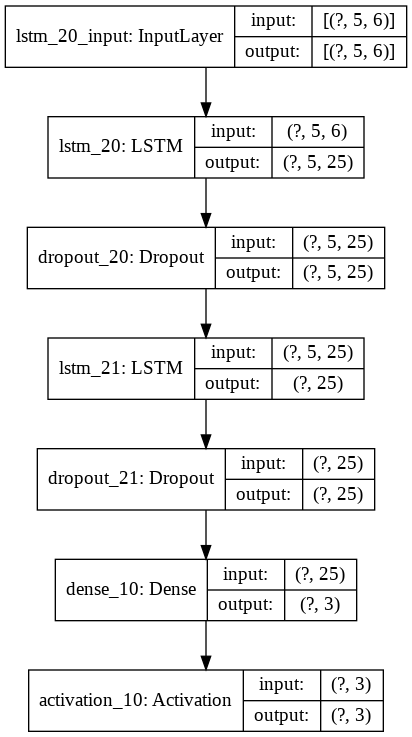

In [322]:
# crear y entrenar la red LSTM

model = tf.keras.Sequential([
tf.keras.layers.LSTM(units=25, return_sequences=True,input_shape=(look_back,6)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.LSTM(units=25, return_sequences=False,input_shape=(look_back,6)),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Dense(units=NUM_CLASSES),
tf.keras.layers.Activation('softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])     #Configura el modelo para entrenar
tf.keras.utils.plot_model(model, to_file='/content/gdrive/My Drive/Colab Notebooks/model_LSTM.png', show_shapes=True, show_layer_names=True)


In [323]:
data_path='/content/gdrive/My Drive/Colab Notebooks/BINANCE/models/'    

In [324]:
#Agregar checkpoint para guardar cada época
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=data_path + '/model-{epoch:02d}.hdf5', verbose=1)

# Entrenamiento del Modelo

In [325]:
#model.fit(trainX, Y, epochs=2, batch_size=32, verbose=2) #trainY debe estar en formato onehot encoding
#history = model.fit(trainX, trainY, epochs=25, batch_size=32, verbose=2, shuffle=True) #trainY debe estar en formato onehot encoding agregamos shuffle
history = model.fit(train_dataset, epochs=8, verbose=2) #trainY debe estar en formato onehot encoding
print(model.summary())
model.save(data_path + "final_model.hdf5")
#plot_model(model, to_file='model_LSTM.png', show_shapes=True, show_layer_names=True)

Epoch 1/8
3334/3334 - 23s - loss: 0.0774 - categorical_accuracy: 0.9732
Epoch 2/8
3334/3334 - 24s - loss: 0.0047 - categorical_accuracy: 0.9988
Epoch 3/8
3334/3334 - 23s - loss: 0.0016 - categorical_accuracy: 0.9995
Epoch 4/8
3334/3334 - 26s - loss: 5.7379e-04 - categorical_accuracy: 0.9999
Epoch 5/8
3334/3334 - 24s - loss: 4.2149e-05 - categorical_accuracy: 1.0000
Epoch 6/8
3334/3334 - 25s - loss: 1.2158e-05 - categorical_accuracy: 1.0000
Epoch 7/8
3334/3334 - 25s - loss: 3.8427e-06 - categorical_accuracy: 1.0000
Epoch 8/8
3334/3334 - 25s - loss: 6.4868e-07 - categorical_accuracy: 1.0000
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 5, 25)             3200      
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 25)             0         
___________________________________________________

In [326]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy'])


Cambiar MSE a cross entropy

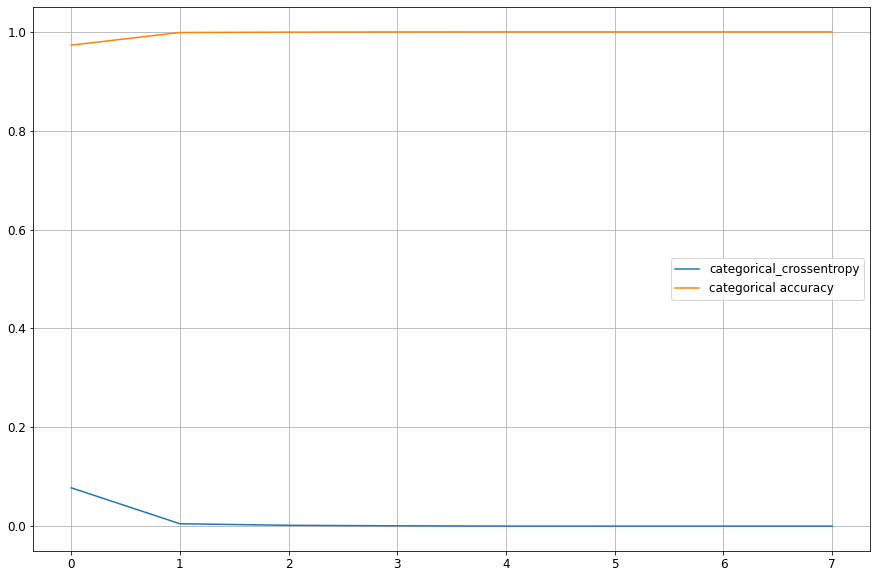

In [327]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(history.history['loss'], label='categorical_crossentropy')
plt.plot(history.history['categorical_accuracy'], label='categorical accuracy')
plt.legend()
plt.show()

# Prueba del Modelo

In [328]:
trainY

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [329]:
trainX

array([[[0.08539487, 0.08182778, 0.08810099, 0.08316131, 0.        ,
         0.5       ],
        [0.08666932, 0.08282251, 0.08917658, 0.08369912, 0.        ,
         0.5       ],
        [0.08585749, 0.08309197, 0.08786436, 0.08522617, 0.        ,
         0.5       ],
        [0.08684926, 0.08474551, 0.09060771, 0.08586343, 0.        ,
         0.5       ],
        [0.08843372, 0.08877728, 0.09220197, 0.09082517, 0.        ,
         0.5       ]],

       [[0.08666932, 0.08282251, 0.08917658, 0.08369912, 0.        ,
         0.5       ],
        [0.08585749, 0.08309197, 0.08786436, 0.08522617, 0.        ,
         0.5       ],
        [0.08684926, 0.08474551, 0.09060771, 0.08586343, 0.        ,
         0.5       ],
        [0.08843372, 0.08877728, 0.09220197, 0.09082517, 0.        ,
         0.5       ],
        [0.09325003, 0.09021478, 0.09458082, 0.09177809, 0.        ,
         0.5       ]],

       [[0.08585749, 0.08309197, 0.08786436, 0.08522617, 0.        ,
         0.5     

In [330]:
trainX.shape

(16666, 5, 6)

In [331]:
# Realizar predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)




In [332]:
trainPredict.shape

(16666, 3)

In [333]:
np.argmax(testPredict[59])

1

In [334]:
decodedTrainPredict = []
for i in trainPredict:
  val = np.argmax(i)
  decodedTrainPredict.append(val)

decodedTrainPredict = np.array(decodedTrainPredict)

In [335]:
decodedTrainPredict.shape

(16666,)

In [336]:
decodedTrainY = []
for i in trainY:
  val = np.argmax(i)
  decodedTrainY.append(val)

decodedTrainY  = np.array(decodedTrainY )

In [337]:
decodedTrainY.shape

(16666,)

In [338]:
decodedTestPredict = []
for i in testPredict:
  val = np.argmax(i)
  decodedTestPredict.append(val)

decodedTestPredict = np.array(decodedTestPredict)

In [339]:
decodedTestPredict.shape

(8206,)

In [340]:
decodedTestY = []
for i in testY:
  val = np.argmax(i)
  decodedTestY.append(val)

decodedTestY  = np.array(decodedTestY )

In [341]:
decodedTestY.shape

(8206,)

In [342]:
np.unique(decodedTestPredict)

array([0, 1, 2])

In [343]:
lastTestY = []
for i in testY:
  lastTestY.append(i)
lastTestY  = np.array(lastTestY)


In [344]:
lastTrainY = []
for i in trainY:
  lastTrainY.append(i)
lastTrainY  = np.array(lastTrainY )


In [345]:
testPredict.shape

(8206, 3)

In [346]:
lastTrainPredict = []
for i in trainPredict:
  lastTrainPredict.append(i)

lastTrainPredict = np.array(lastTrainPredict)


In [347]:
lastTestPredict = []
for i in testPredict:
  lastTestPredict.append(i)

lastTestPredict = np.array(lastTestPredict)

In [348]:
lastTestPredict.shape

(8206, 3)

In [349]:
#n_classes = 5
n_classes = NUM_CLASSES
# Plot linewidth.
lw = 2


# Grafica de Receiver Operating Characteristic de cada clase.
Se calcula para cada clase: 
* TRF = True Positive Rate
* FPR = False Positive Rate

Para todas: 
* Micro Average
* Macro Average

Para training dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



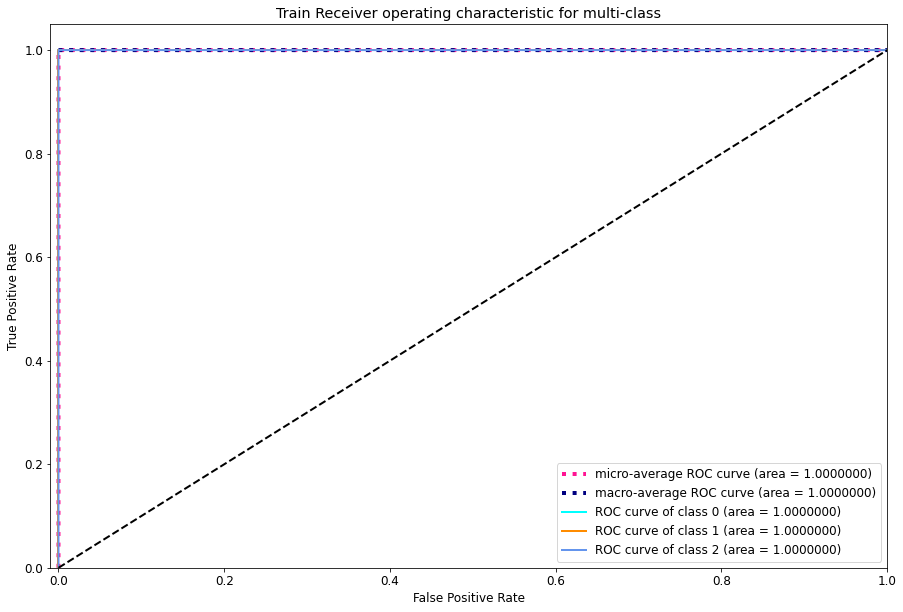

In [353]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lastTrainY[:, i], lastTrainPredict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(decodedTestY, decodedTestPredict)
fpr["micro"], tpr["micro"], _ = roc_curve(lastTrainY.ravel(), lastTrainPredict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[15,10])
#plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.7f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()


Para Testing Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



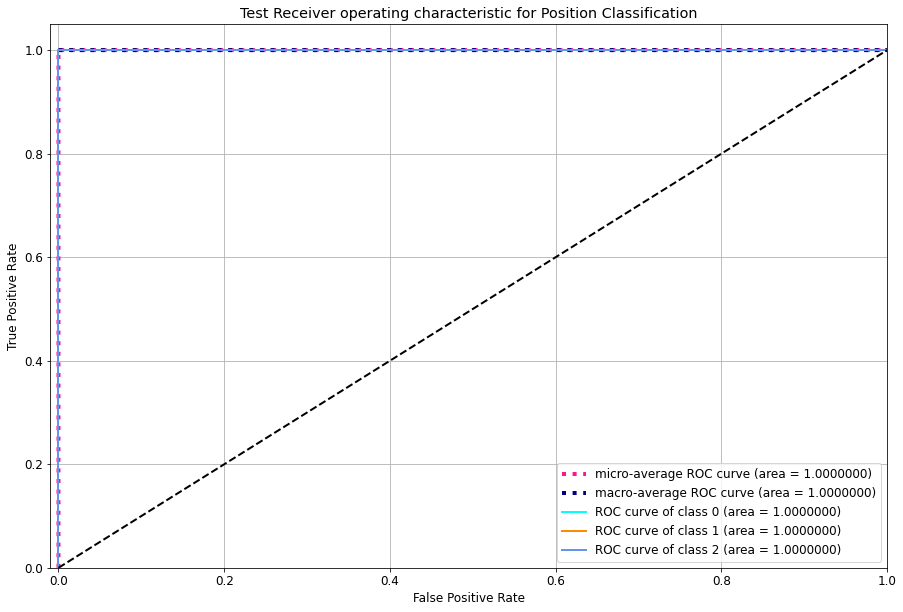

In [351]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(lastTestY[:, i], lastTestPredict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr_rf, tpr_rf, thresholds_rf = roc_curve(decodedTestY, decodedTestPredict)
fpr["micro"], tpr["micro"], _ = roc_curve(lastTestY.ravel(), lastTestPredict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=[15,10])
#plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.7f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.grid(True)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Receiver operating characteristic for Position Classification')
plt.legend(loc="lower right")
plt.show()


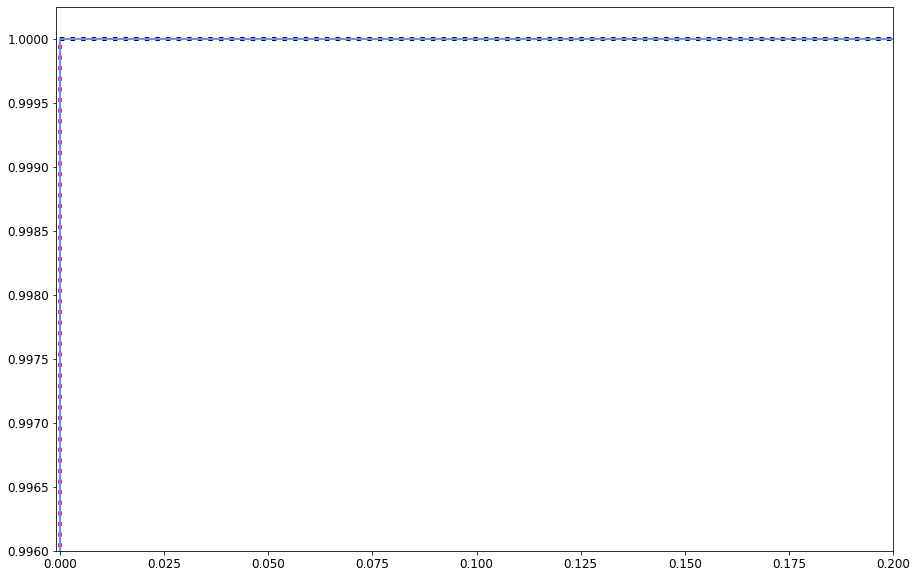

In [352]:
# Zoom in view of the upper left corner.
#plt.figure(2)
plt.figure(figsize=[15,10])
plt.xlim(-0.001, 0.2)
plt.ylim(0.996, 1.00025)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.7f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green','magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.7f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
